In [2]:
from keras import layers
from keras.callbacks import ModelCheckpoint,EarlyStopping
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import mpl_finance as mpf
import FinanceDataReader as fdr
from keras import backend as K
import tensorflow as tf
import warnings
from collections import deque
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = 17,9
sns.set_style('darkgrid')


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\dhko23\AppData\Local\anaconda3\envs\quantproject\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\dhko23\AppData\Local\Temp\ipykernel_28364\4067868309.py", line 1, in <module>
    from keras import layers
  File "C:\Users\dhko23\AppData\Local\anaconda3\envs\quantproject\Lib\site-packages\keras\__init__.py", line 3, in <module>
    from keras import __internal__
  File "C:\Users\dhko23\AppData\Local\anaconda3\envs\quantproject\Lib\site-packages\keras\__internal__\__init__.py", line 3, in <module>
    from keras.__internal__ import backend
  File "C:\Users\dhko23\AppData\Local\anaconda3\envs\quantproject\Lib\site-packages\keras\__internal__\backend\__init__.py", line 3, in <module>
    from keras.src.backend import _initialize_variables as initialize_variables
  File "C:\Users\dhko23\AppData\Local\anaconda3\envs\quantproject\Lib\site-packag

In [39]:
data = fdr.DataReader('^KS200',start='2020-1-1',end='2023-4-18')
kospi200 = data

In [40]:
kospi200

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,294.190002,294.570007,289.959991,290.350006,290.350006,66200
2020-01-03,293.100006,294.880005,289.040009,290.739990,290.739990,79800
2020-01-06,287.730011,289.410004,287.489990,288.429993,288.429993,70000
2020-01-07,290.010010,292.260010,289.640015,291.230011,291.230011,65300
2020-01-08,288.940002,291.010010,287.299988,289.420013,289.420013,124500
...,...,...,...,...,...,...
2023-04-11,328.000000,331.579987,326.869995,330.869995,330.869995,148400
2023-04-12,330.880005,332.799988,329.769989,332.089996,332.089996,252100
2023-04-13,330.059998,333.089996,329.630005,333.089996,333.089996,172600


In [41]:
kospi200['Close'][int(len(kospi200)*0.7):].describe()

count    244.000000
mean     317.094139
std       16.312474
min      281.359985
25%      308.140000
50%      316.029999
75%      323.645004
max      355.429993
Name: Close, dtype: float64

In [42]:
kospi200['Close'][:int(len(kospi200)*0.7)].describe()

count    569.000000
mean     356.872724
std       61.636755
min      199.279999
25%      302.329987
50%      367.630005
75%      413.950012
max      440.399994
Name: Close, dtype: float64

In [5]:
x = deque()
for i in range(5):
    x.append(kospi200.iloc[i])
pd.DataFrame(x)

,Open,High,Low,Close,Adj Close,Volume
2020-01-02,294.190002,294.570007,289.959991,290.350006,290.350006,66200.0
2020-01-03,293.100006,294.880005,289.040009,290.739990,290.739990,79800.0
2020-01-06,287.730011,289.410004,287.489990,288.429993,288.429993,70000.0
2020-01-07,290.010010,292.260010,289.640015,291.230011,291.230011,65300.0
2020-01-08,288.940002,291.010010,287.299988,289.420013,289.420013,124500.0


In [43]:
def rmse(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_pred-y_true)))

def EMA(df, n):
    """
    Compute the exponential moving average of a time series.

    Args:
    - df (array-like): The time series to be smoothed.
    - n (int): The number of periods over which to compute the EMA.

    Returns:
    - ema (numpy.ndarray): The EMA of the time series.
    """
    sma = deque(maxlen=n)
    ema = np.zeros(len(df))
    alpha = 2 / (n + 1)

    for i, x in enumerate(df):
        if i < n:
            sma.append(x)
            ema[i] = sum(sma) / len(sma)
        else:
            sma.append(x)
            ema[i] = alpha * x + (1 - alpha) * ema[i-1]

    return ema

def kalman_smoother(y, A, C, Q, R):
    n = len(y)
    x_pred = np.zeros((n+1, 1))
    P_pred = np.zeros((n+1, 1, 1))
    x_smooth = np.zeros((n+1, 1))
    P_smooth = np.zeros((n+1, 1, 1))
    K = np.zeros((n+1, 1, 1))

    # Initialization
    x_pred[0] = np.mean(y)
    P_pred[0] = np.var(y)

    # Filtering
    for t in range(n):
        # Prediction step
        x_pred[t+1] = A @ x_smooth[t]
        P_pred[t+1] = A @ P_smooth[t] @ A.T + Q

        # Update step
        K[t+1] = P_pred[t+1] @ C.T @ np.linalg.inv(C @ P_pred[t+1] @ C.T + R)
        x_smooth[t+1] = x_pred[t+1] + K[t+1] @ (y[t] - C @ x_pred[t+1])
        P_smooth[t+1] = P_pred[t+1] - K[t+1] @ C @ P_pred[t+1]

    # Compute smoothed observations
    y_smooth = np.zeros(n)
    for t in range(n):
        y_smooth[t] = C @ x_smooth[t+1]

    return y_smooth


A = np.array([[1]])
C = np.array([[1]])
Q = np.array([[np.var(kospi200['Close'])/10]])
R = np.array([[np.var(kospi200['Close'])]])



def SMA(df,n):
    sma =deque()
    sma_lst = []
    for i in df:
        sma.append(i)
        if len(sma)>n:
            sma.popleft()
        sma_lst.append(sum(sma)/len(sma))
    return sma_lst

In [46]:
y_smooth= kalman_smoother(kospi200['Close'].values, A, C, Q, R)
y_smooth = y_smooth[20:]

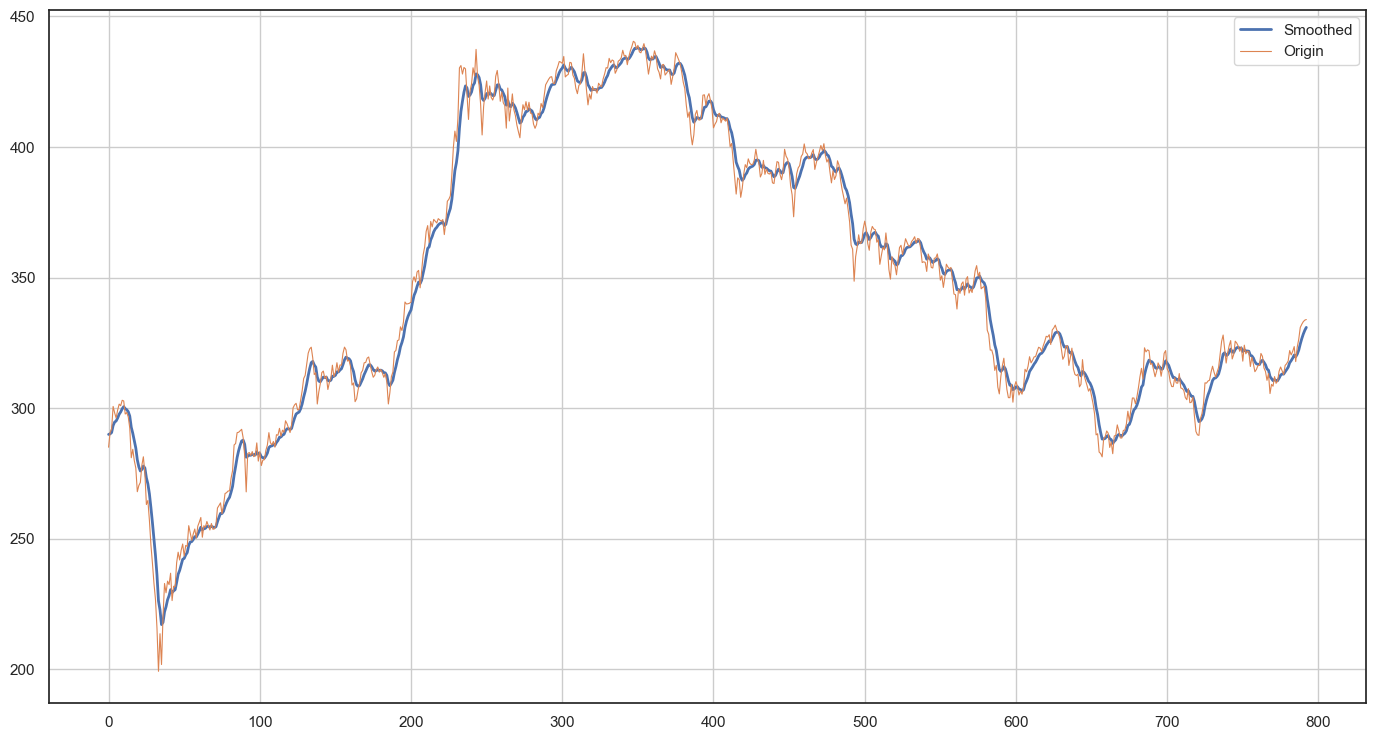

In [88]:
plt.plot(y_smooth,label='Smoothed',lw=2)
plt.plot(list(kospi200['Close'])[20:],label='Origin',lw=.8)
plt.grid(True)
plt.legend()

In [12]:
y = EMA(y_smooth,5)
y_lst = []
for i in range(3,len(y)):
    y_lst.append(y[i])
np.array(y_lst).reshape(np.array(y_lst).shape[0],1)

array([[291.02130738],
       [291.74979416],
       [292.86305431],
       [293.98258411],
       [295.2078671 ],
       [296.31933316],
       [297.4626402 ],
       [298.49596967],
       [298.93067154],
       [299.08808829],
       [298.94512594],
       [298.28796589],
       [296.41319936],
       [294.40478552],
       [292.1249829 ],
       [289.66178467],
       [286.51439621],
       [283.52915818],
       [280.99880556],
       [279.50928937],
       [278.95300843],
       [278.33537212],
       [276.6637758 ],
       [274.7703765 ],
       [272.24976158],
       [268.80536334],
       [264.59399892],
       [259.69710032],
       [254.36010557],
       [248.29360831],
       [240.92810108],
       [234.88967266],
       [228.97810933],
       [225.32388416],
       [224.22721944],
       [224.1540396 ],
       [224.98617059],
       [226.06318736],
       [227.55589725],
       [228.17360094],
       [228.80431887],
       [229.37196439],
       [230.67817804],
       [232

In [9]:
def SMA(df,n):
    x = deque()
    x_lst= []
    for i in df:
        x.append(i)
        if len(x)>n:
            x.popleft()
        x_lst.append(sum(x)/len(x))
    return(x_lst)

(550, 5, 1) (550, 1, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 5, 64)             256       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 5, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 3, 32)             6176      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 3, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 max_pooling1d_14 (MaxPoolin  

2023-06-08 00:07:41.241601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


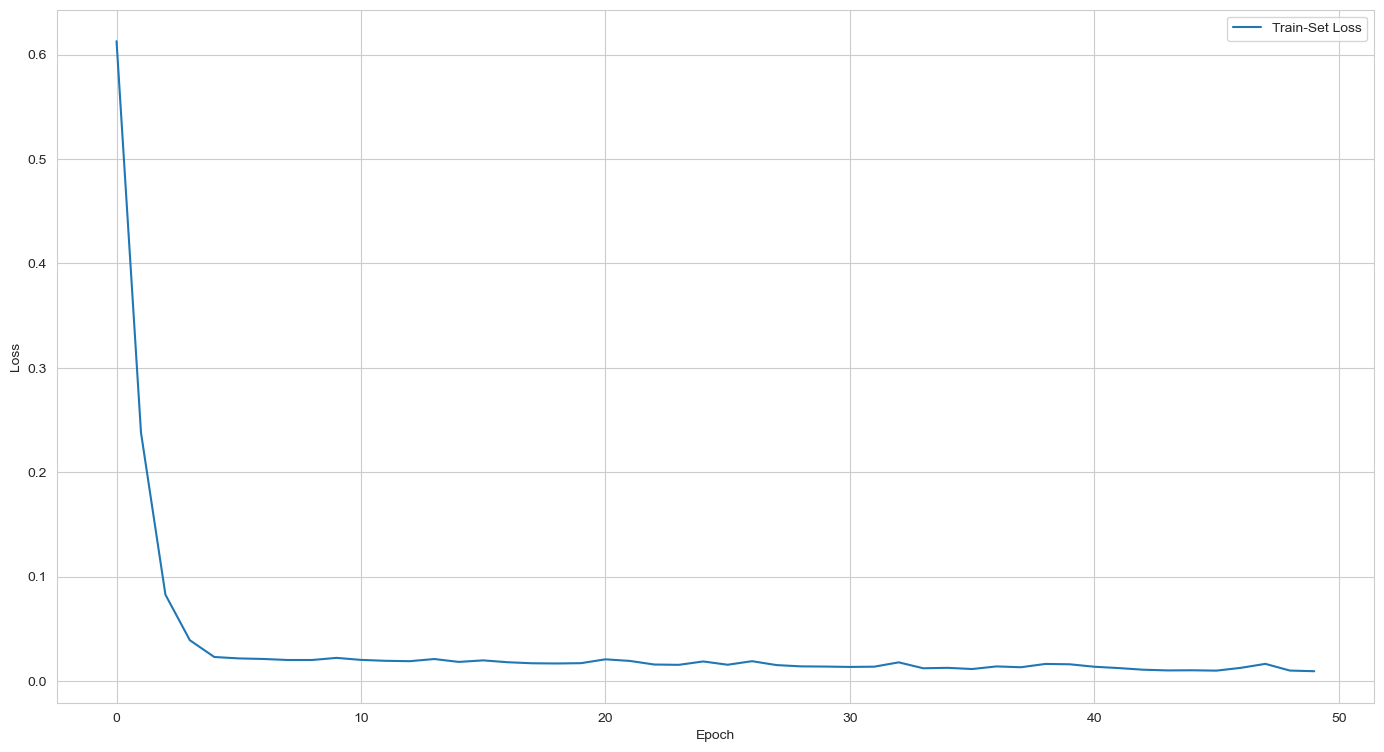

2023-06-08 00:07:47.958453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [48]:
import numpy as np
class oneDimensionalCNN:
    def __init__(self,data):
        self.data = data
        self.scaler = MinMaxScaler(feature_range=(0,1))
    def create_input_output_data(self,x,n,m):
        """
        :param x: input
        :param y: output
        :param n: input dimension
        :param m: output dimension
        :return: dimension scaled input data , dimension scaled output data
        """
        y= SMA(x,9)
        x_lst = []
        y_lst = []
        for i in range(n, len(x)-m+1):
            x_lst.append(x[i-n:i])
            y_lst.append(x[i:i+m])
        return np.array(x_lst),np.array(y_lst)

    def data_preprocessing(self,data,train_test_split_ratio=0.7):

        trained_scaled = self.scaler.fit_transform(data)
        x_train, x_test = trained_scaled[:int(len(data)*train_test_split_ratio)] , trained_scaled[int(len(data)*train_test_split_ratio):]


        x_train_lst , y_train_lst = self.create_input_output_data(x_train,5,1)
        x_test_lst  = self.create_input_output_data(x_test,5,1)[0]

        return np.reshape(x_train_lst,(x_train_lst.shape[0],x_train_lst.shape[1],1)),\
            np.reshape(y_train_lst,(y_train_lst.shape[0],y_train_lst.shape[1],1)), \
            np.reshape(x_test_lst,(x_test_lst.shape[0],x_test_lst.shape[1],1))

    def train_model(self,kernel_size=3,pool_size=1,activation='relu'):
        x_train_lst, y_train_lst,x_test_lst = self.data_preprocessing(self.data)
        print(x_train_lst.shape,y_train_lst.shape)
        model = tf.keras.Sequential([
            layers.Conv1D(filters=64,kernel_size=kernel_size,kernel_initializer='glorot_uniform',activation=activation,padding='same',input_shape=(x_train_lst.shape[1],1)),
            layers.MaxPooling1D(pool_size=pool_size),
            layers.Conv1D(filters=32,kernel_size=kernel_size,kernel_initializer='glorot_uniform',activation=activation,input_shape=(x_train_lst.shape[1],64)),
            layers.MaxPooling1D(pool_size=pool_size),
            layers.Conv1D(filters=16,kernel_size=kernel_size,kernel_initializer='glorot_uniform',activation=activation,input_shape=(x_train_lst.shape[1],32)),
            layers.MaxPooling1D(pool_size=pool_size),
            layers.Flatten(),
            layers.Dense(5,activation='relu'),
            layers.Dense(1)
        ])

        model.compile(optimizer='adam',loss=rmse,metrics=['accuracy'])
        model.summary()
        history = model.fit(x_train_lst,y_train_lst,epochs=50,batch_size=32,
                            verbose=False)

        y_loss = history.history['loss']
        x_len = np.arange(len(y_loss))
        plt.figure()

        plt.plot(x_len,y_loss,label='Train-Set Loss')
        plt.legend(loc='upper right')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        predicted_value = model.predict(x_test_lst)
        predicted_value = self.scaler.inverse_transform(predicted_value)

        return predicted_value

cnn = oneDimensionalCNN(np.array(y_smooth).reshape(-1,1))
train_ = cnn.train_model()



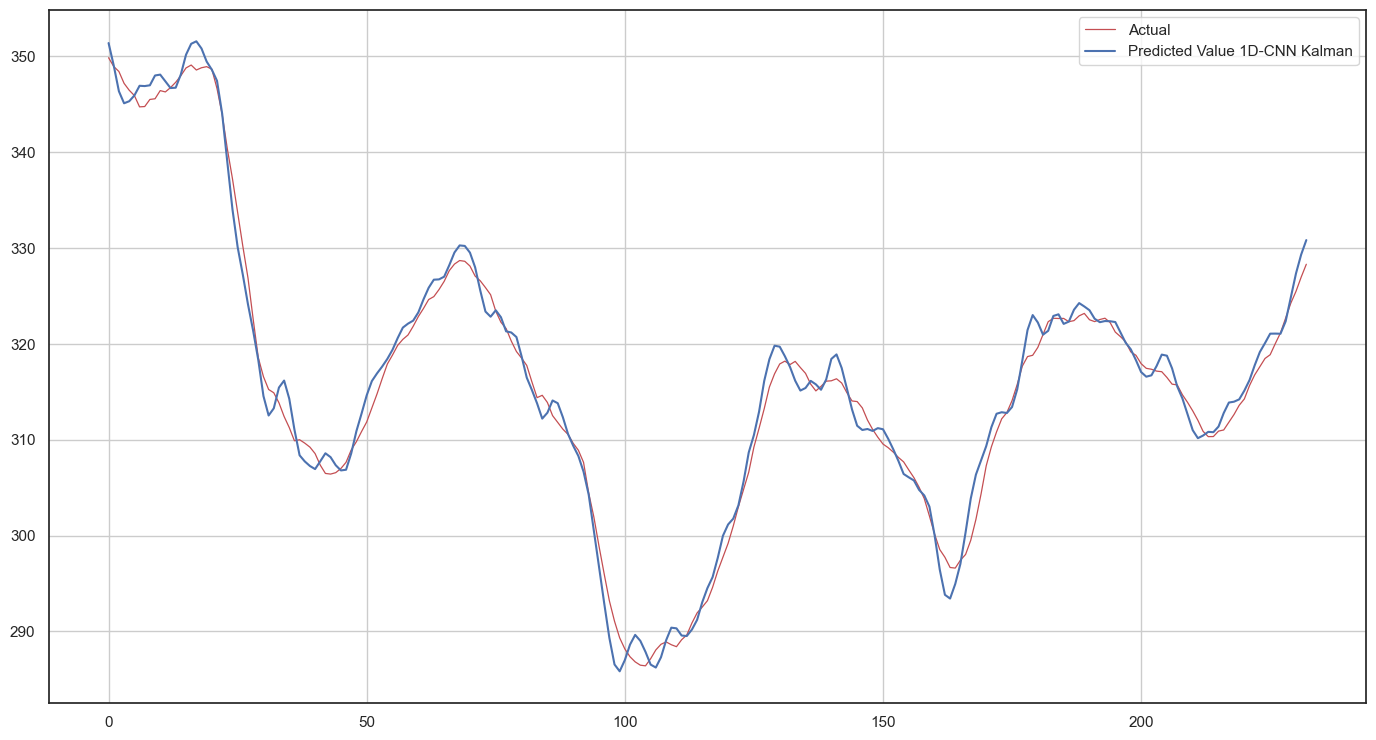

In [97]:
plt.plot(SMA(kospi200['Close'],9)[-len(train_):],label='Actual',lw=.9,color='r')
plt.plot(train_,label='Predicted Value 1D-CNN Kalman')
plt.grid(True)
plt.legend()

(564, 5, 1) (564, 1, 1)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 5, 64)             256       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 5, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 3, 32)             6176      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 3, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 max_pooling1d_20 (MaxPoolin 

2023-06-08 03:01:05.866842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


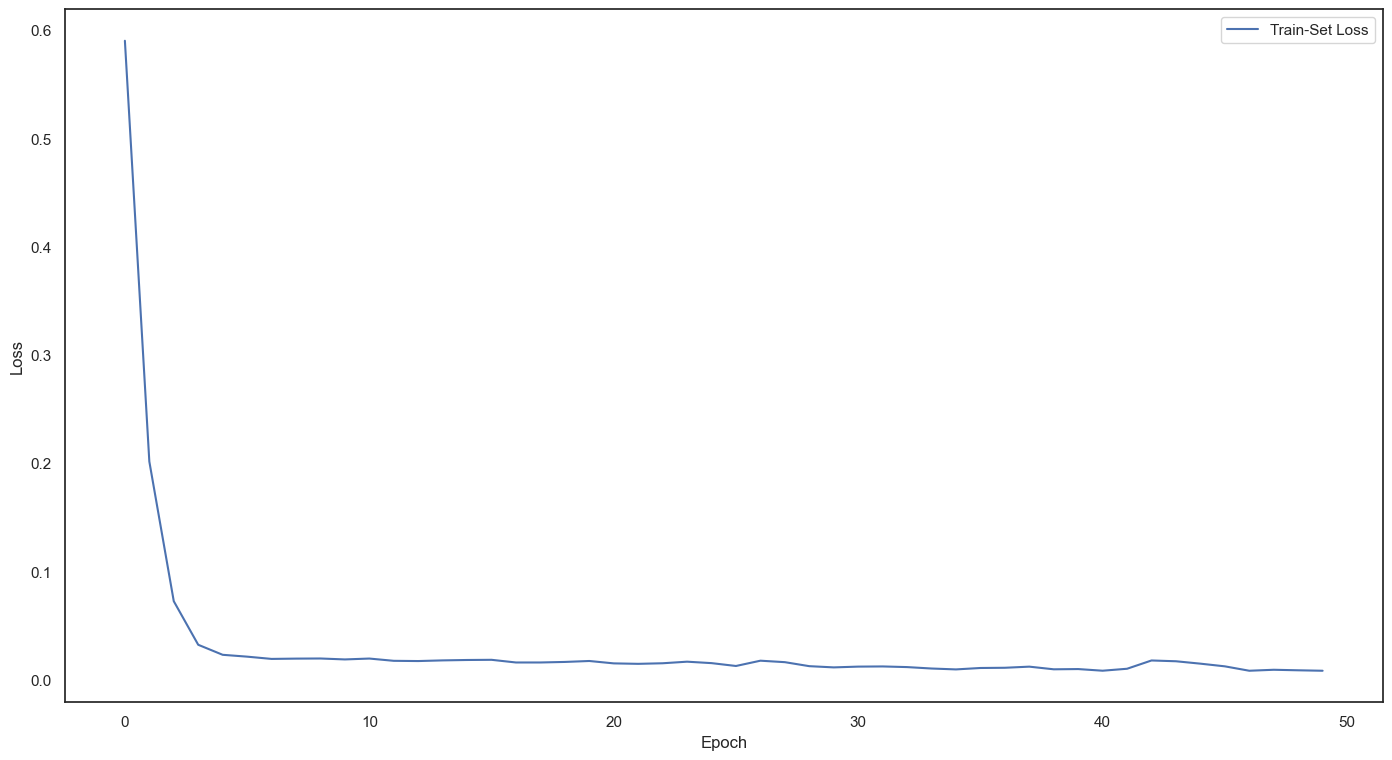

2023-06-08 03:01:16.663728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [104]:
cnn = oneDimensionalCNN(np.array(SMA(kospi200['Close'],9)).reshape(-1,1))
just_train_ = cnn.train_model()

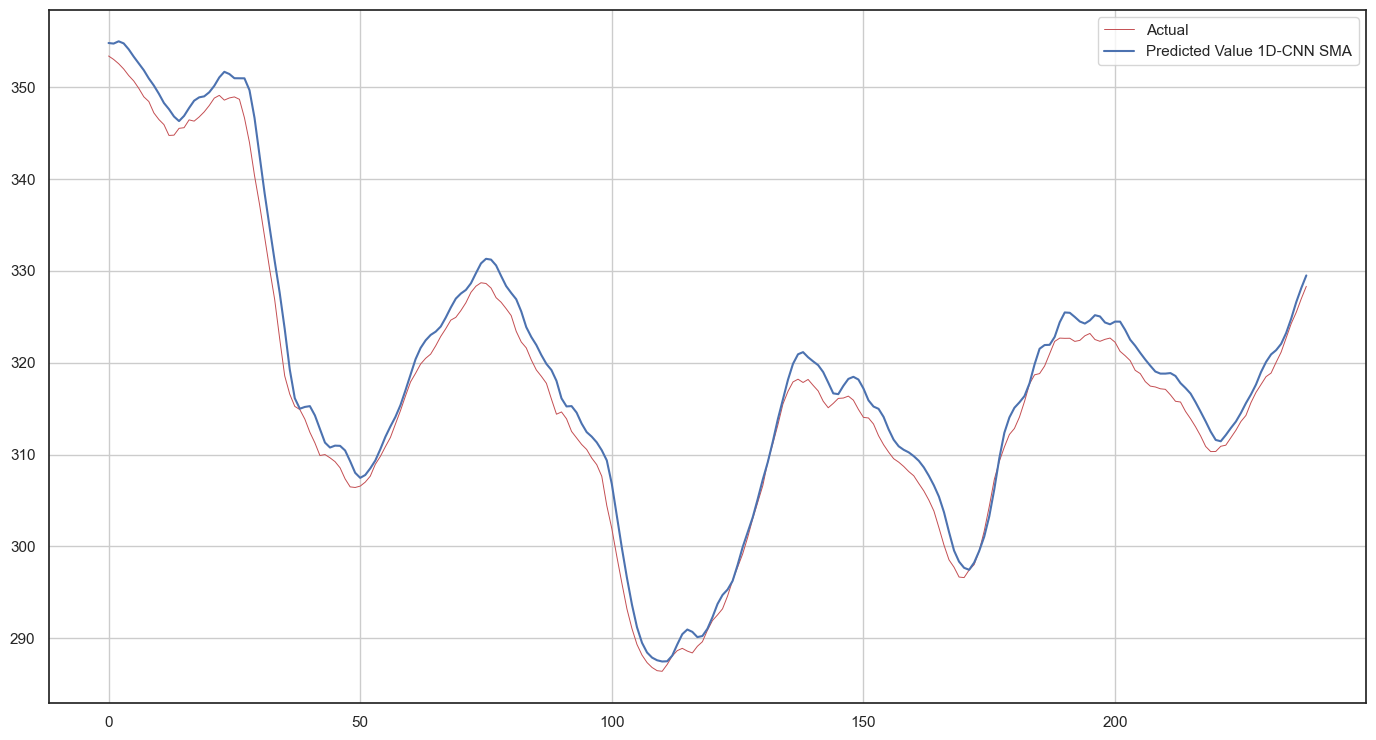

In [105]:
plt.plot(SMA(kospi200['Close'],9)[-len(just_train_):],label='Actual',color='r',lw=.7)
plt.plot(just_train_,label='Predicted Value 1D-CNN SMA')
plt.grid(True)
plt.legend()

plt.plot(EMA(kospi['Close'],9)[-len(train_):],label='Actual')
plt.plot(ust_lstm_train_,label='Predicted Value')
plt.legend()


In [159]:
from keras.models import  Sequential
from keras.layers import LSTM,Dense,Dropout

(550, 5, 1) (550, 1) (233, 5, 1)


2023-06-08 00:09:02.617543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 00:09:02.985634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 00:09:03.067043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 00:09:03.153205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 00:09:03.311180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 00:09:03.431536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 00:09:03.557711: I tensorflow/core/grappler/optimizers/cust

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 64)             16896     
                                                                 
 lstm_4 (LSTM)               (None, 5, 32)             12416     
                                                                 
 lstm_5 (LSTM)               (None, 5, 16)             3136      
                                                                 
 flatten_7 (Flatten)         (None, 80)                0         
                                                                 
 dense_14 (Dense)            (None, 5)                 405       
                                                                 
 dense_15 (Dense)            (None, 1)                 6         
                                                                 
Total params: 32,859
Trainable params: 32,859
Non-trai

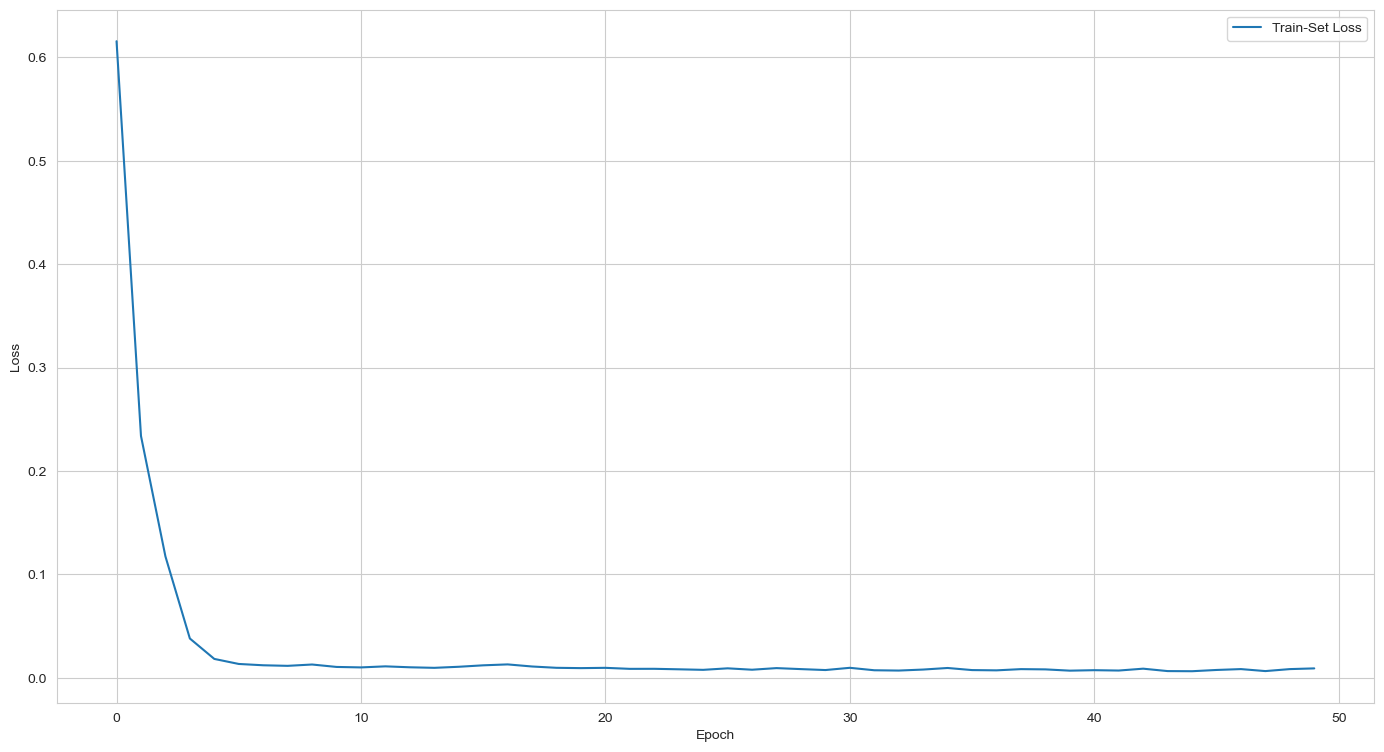

2023-06-08 00:09:24.336434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 00:09:24.460273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 00:09:24.531095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 00:09:24.600689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [52]:
class Lstm:
    def __init__(self,data):
        self.data = data
        self.scaler = MinMaxScaler(feature_range=(0,1))
    def create_input_output_data(self,x,n,m):
        """
        :param x: input
        :param y: output
        :param n: input dimension
        :param m: output dimension
        :return: dimension scaled input data , dimension scaled output data
        """
        y = SMA(x,9)
        x_lst = []
        y_lst = []
        for i in range(n, len(x)-m+1):
            x_lst.append(x[i-n:i])
            y_lst.append(y[i:i+m])
        return np.array(x_lst),np.array(y_lst)

    def data_preprocessing(self,data,train_test_split_ratio=0.7):

        trained_scaled = self.scaler.fit_transform(data)
        x_train, x_test = trained_scaled[:int(len(data)*train_test_split_ratio)] , trained_scaled[int(len(data)*train_test_split_ratio):]


        x_train_lst , y_train_lst = self.create_input_output_data(x_train,5,1)
        x_test_lst  = self.create_input_output_data(x_test,5,1)[0]

        return np.reshape(x_train_lst,(x_train_lst.shape[0],x_train_lst.shape[1],1)),\
            np.reshape(y_train_lst,(y_train_lst.shape[0],1)), \
            np.reshape(x_test_lst,(x_test_lst.shape[0],x_test_lst.shape[1],1))

    def train_model(self):
        x_train_lst, y_train_lst,x_test_lst = self.data_preprocessing(self.data)
        print(x_train_lst.shape,y_train_lst.shape,x_test_lst.shape)
        regression = tf.keras.Sequential([
        layers.LSTM(units=64,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(x_train_lst.shape[1],1)),
        layers.LSTM(units=32,kernel_initializer='glorot_uniform',return_sequences=True),
        layers.LSTM(units=16,kernel_initializer='glorot_uniform',return_sequences=True),
        layers.Flatten(),
        layers.Dense(5,activation='relu'),
        layers.Dense(1)
        ])
        regression.compile(optimizer='adam',loss=rmse)

#fitting the network
        history = regression.fit(x_train_lst,y_train_lst,batch_size=30,epochs=50,verbose=False)
        regression.summary()



        y_loss = history.history['loss']
        x_len = np.arange(len(y_loss))
        plt.figure()

        plt.plot(x_len,y_loss,label='Train-Set Loss')
        plt.legend(loc='upper right')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        predicted_value = regression.predict(x_test_lst)
        predicted_value = self.scaler.inverse_transform(predicted_value)

        return predicted_value

lstm = Lstm(np.array(y_smooth).reshape(-1,1))
lstm_train_ = lstm.train_model()

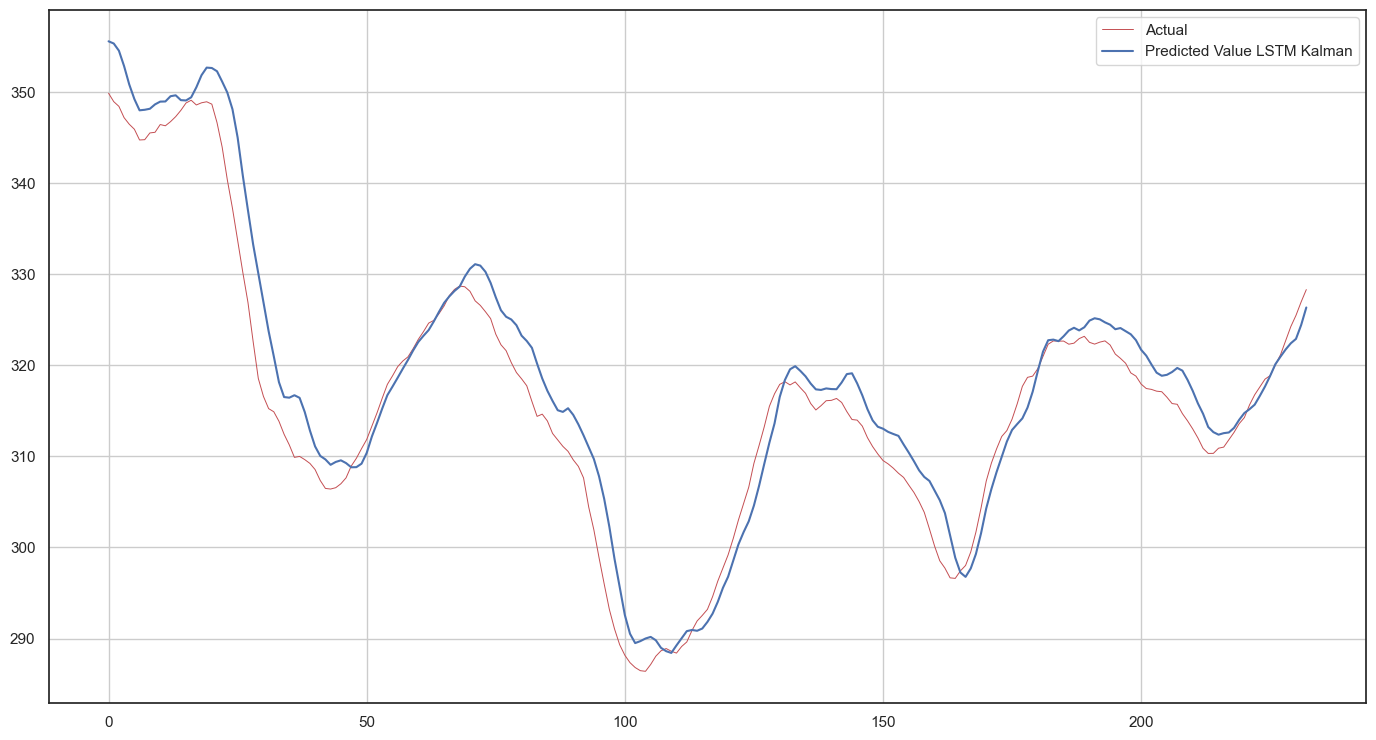

In [99]:
plt.plot(list(SMA(kospi200['Close'],9)[-len(lstm_train_):]),label='Actual',color='r',lw=.7)
plt.plot(lstm_train_,label='Predicted Value LSTM Kalman')
plt.grid(True)
plt.legend()

(564, 5, 1) (564, 1) (239, 5, 1)


2023-06-08 03:00:02.022454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 03:00:02.525595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 03:00:02.808568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 03:00:03.036238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 03:00:03.471811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 03:00:03.709581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 03:00:03.851418: I tensorflow/core/grappler/optimizers/cust

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 64)             16896     
                                                                 
 lstm_13 (LSTM)              (None, 5, 32)             12416     
                                                                 
 lstm_14 (LSTM)              (None, 5, 16)             3136      
                                                                 
 flatten_10 (Flatten)        (None, 80)                0         
                                                                 
 dense_20 (Dense)            (None, 5)                 405       
                                                                 
 dense_21 (Dense)            (None, 1)                 6         
                                                                 
Total params: 32,859
Trainable params: 32,859
Non-tra

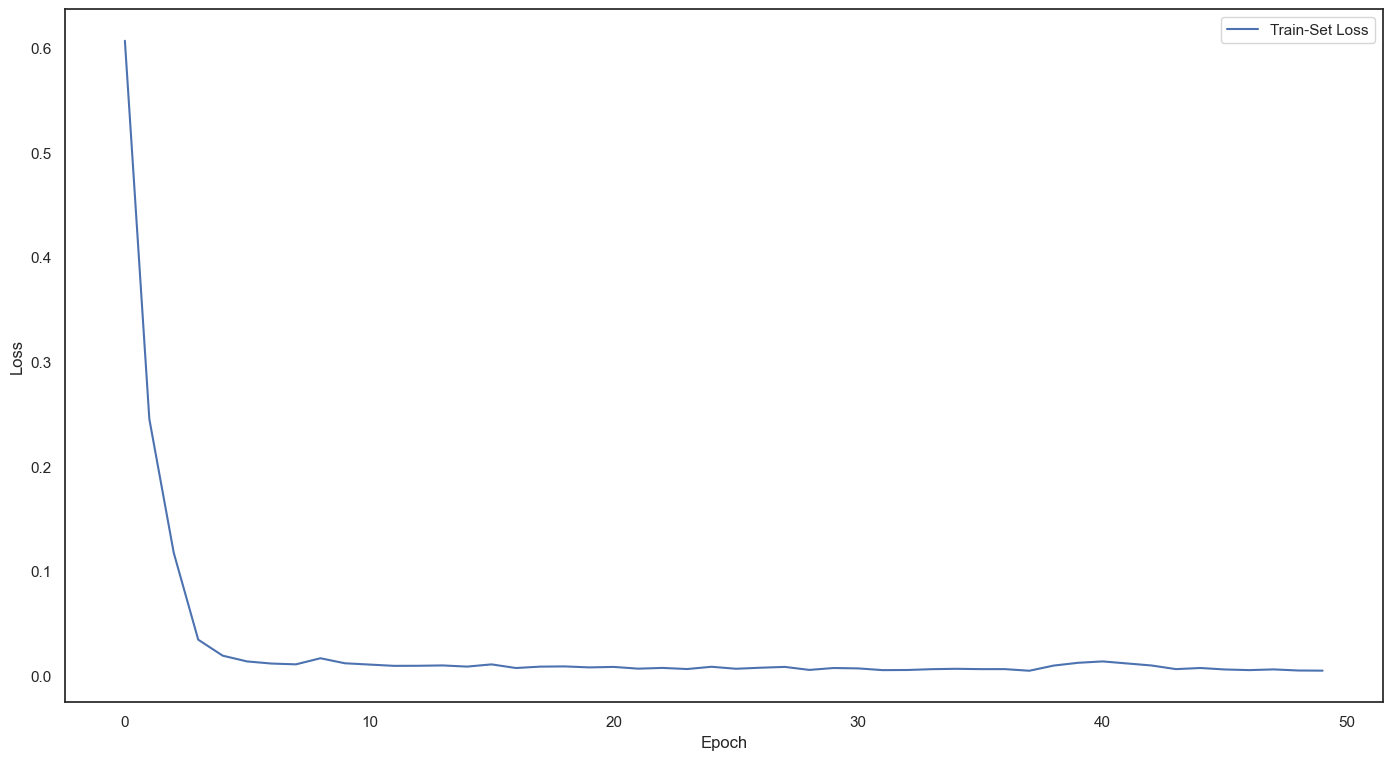

2023-06-08 03:00:20.557818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 03:00:20.645269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 03:00:20.701393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 03:00:20.758998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [101]:
lstn_ = Lstm(np.array(SMA(kospi200['Close'],9)).reshape(-1,1))
ust_lstm_train_ = lstn_.train_model()

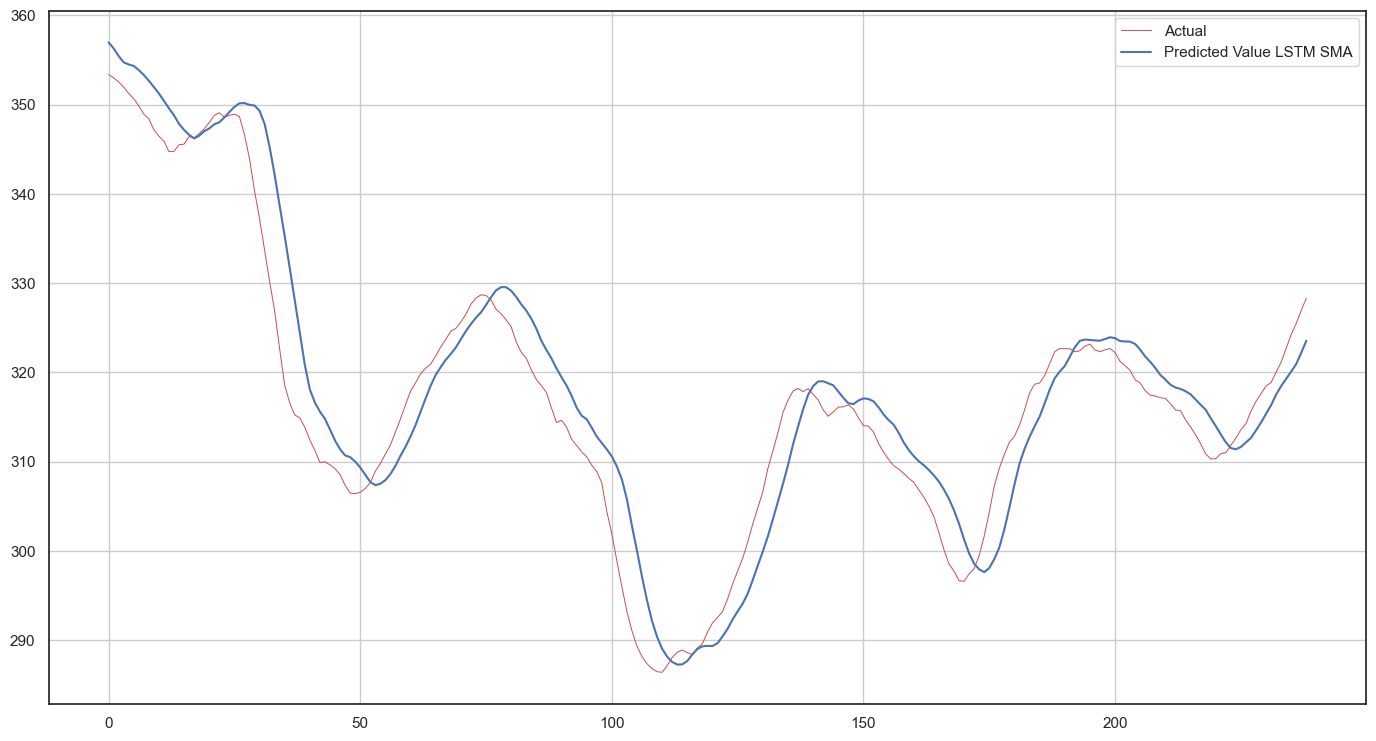

In [102]:
#plt.plot(list(kospi[-len(train_):]),label='Origin')
plt.plot(SMA(kospi200['Close'],9)[-len(ust_lstm_train_):],label='Actual',color='r',lw=.7)
plt.plot(ust_lstm_train_,label='Predicted Value LSTM SMA')
plt.grid(True)
plt.legend()


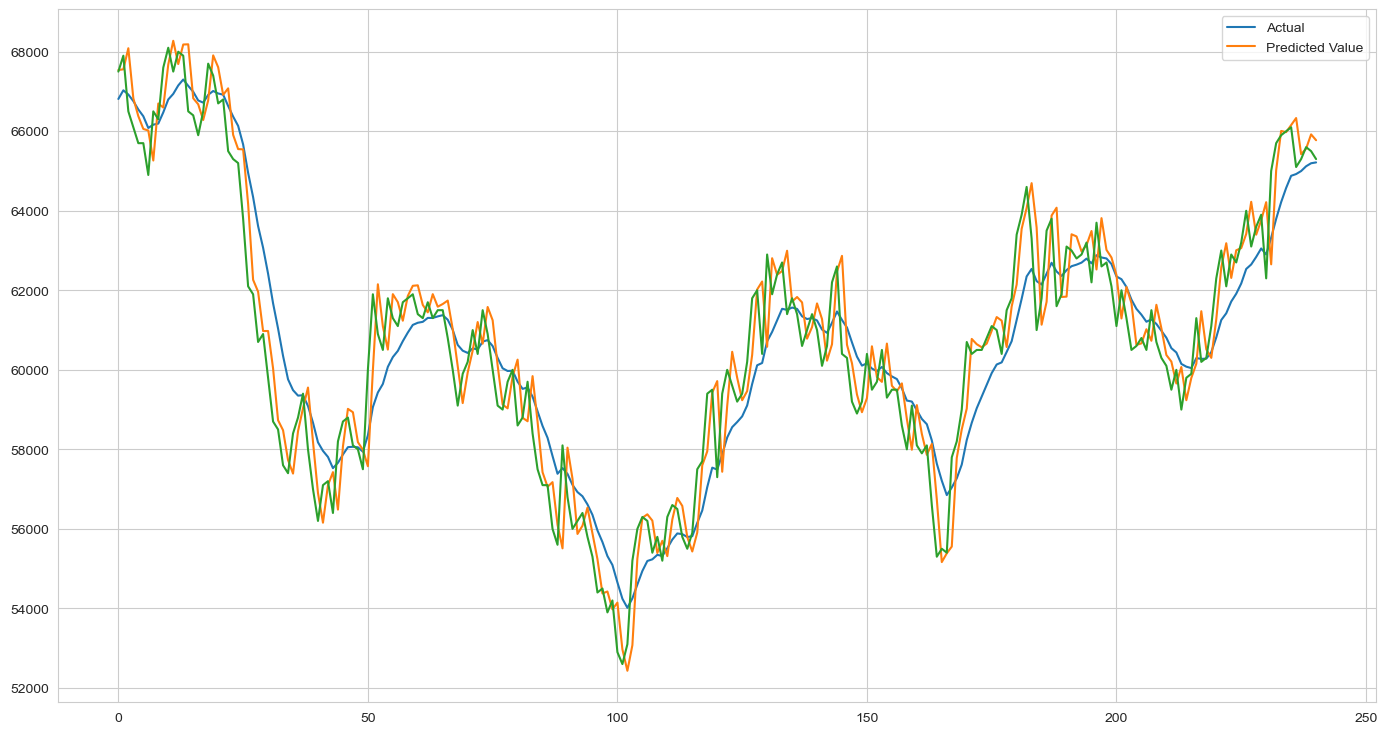

In [264]:
plt.plot(EMA(kospi['Close'],9)[-len(train_)-6:],label='Actual')
plt.plot(just_train_,label='Predicted Value')
plt.plot(list(kospi['Close'][-241:]))
plt.legend()


In [60]:
def RMSE(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean(np.square(y_true-y_pred)))

def RMSLE(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean(np.square(np.log(y_pred+1)-np.log(y_true+1))))

def MAE(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(abs(y_true-y_pred))


In [162]:
RMSE(EMA(kospi['Close'],9)[-len(train_):],lstm_train_)

4227.4319305056615

In [239]:
len(ust_lstm_train_)

241

In [106]:
result = pd.DataFrame(columns=['MAE','RMSE','RMSLE'])
result.loc['LSTM + Kalman','RMSE'] = RMSE(SMA(kospi200['Close'],9)[-235:],lstm_train_)
result.loc['LSTM + Kalman','MAE'] = MAE(SMA(kospi200['Close'],9)[-235:],lstm_train_)
result.loc['LSTM + Kalman','RMSLE'] = RMSLE(SMA(kospi200['Close'],9)[-235:],lstm_train_)
result.loc['CNN + Kalman','RMSE'] = RMSE(SMA(kospi200['Close'],9)[-235:],train_)
result.loc['CNN + Kalman','MAE'] = MAE(SMA(kospi200['Close'],9)[-235:],train_)
result.loc['CNN + Kalman','RMSLE'] = RMSLE(SMA(kospi200['Close'],9)[-235:],train_)
result.loc['LSTM ','RMSE'] = RMSE(SMA(kospi200['Close'],9)[-241:],ust_lstm_train_)
result.loc['LSTM ','MAE'] = MAE(SMA(kospi200['Close'],9)[-241:],ust_lstm_train_)
result.loc['LSTM ','RMSLE'] = RMSLE(SMA(kospi200['Close'],9)[-241:],ust_lstm_train_)
result.loc['CNN ','RMSE'] = RMSE(SMA(kospi200['Close'],9)[-241:],just_train_)
result.loc['CNN ','MAE'] = MAE(SMA(kospi200['Close'],9)[-241:],just_train_)
result.loc['CNN ','RMSLE'] = RMSLE(SMA(kospi200['Close'],9)[-241:],just_train_)

In [107]:
result

,MAE,RMSE,RMSLE
LSTM + Kalman,16.647089,21.600354,0.067403
CNN + Kalman,16.312978,21.142177,0.066275
LSTM,17.659399,22.880552,0.071134
CNN,17.480458,22.580915,0.070246


In [163]:
RMSE(EMA(kospi['Close'],9)[-len(train_):],train_)

4276.692941258781